## KMeans Analysis Plots and Pipeline Check 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# ROOT_DIR = Path(os.getcwd())
ROOT_DIR = "d:/Desktop/Data Science Learning/DS Self Projects/IITG Capstone/Stock Market Anomaly Detection/stock-anomaly-detector/"

In [3]:
import os
import sys

# Set the project root directory
project_root = ROOT_DIR

# Change the working directory to the project root
os.chdir(project_root)


# Adding the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.detectors.kmeans import (
    build_feature_matrix,
    split_by_date,
    scale_features,
    fit_kmeans,
    compute_kmeans_distance,
    compute_cluster_thresholds,
    detect_kmeans_anomaly
)

In [7]:
from src.detectors.rules import detect_rule_anomaly

from src.features.range import compute_range_percentile
from src.features.returns import compute_daily_return, compute_return_zscore
from src.features.volume import compute_volume_zscore

from src.data.load import load_ticker_csv
from src.data.clean_ohlcv import clean_ohlcv
from src.data.validate import validate_ohlcv

#### Load Tickers & Compute Features

In [10]:
DATA_PATH = ROOT_DIR + "data/raw"
PATH = Path(DATA_PATH)

tickers = ["QQQ", "AMZN", "GOOGL", "MSFT", "NVDA", "TSLA", "FB"]

feature_frames = []

for ticker in tickers:

    df = load_ticker_csv(PATH / f"{ticker}.csv")
    df, issues = validate_ohlcv(df)

    if issues:
        df = clean_ohlcv(df, issues, ticker)
        validate_ohlcv(df, strict=True)

    # compute features
    ret = compute_daily_return(df)
    ret_z = compute_return_zscore(ret)
    vol_z = compute_volume_zscore(df["volume"])
    range_pct = compute_range_percentile(df)

    feat_df = pd.DataFrame({
        "date": df["date"],
        "ticker": ticker,
        "ret": ret,
        "ret_z": ret_z,
        "vol_z": vol_z,
        "range_pct": range_pct
    })

    feature_frames.append(feat_df)

df_features = pd.concat(feature_frames, ignore_index=True)

df_features.head()


2026-01-01 02:07:09,423 - INFO - [data.load]: ✅ All required columns exist
2026-01-01 02:07:09,456 - INFO - QQQ | Row Count before: 5301
2026-01-01 02:07:09,461 - INFO - QQQ | Row Count after: 5300
2026-01-01 02:07:09,463 - INFO - QQQ | Reasons:
2026-01-01 02:07:09,463 - INFO - High < max(open, close, low)
2026-01-01 02:07:10,256 - INFO - [data.load]: ✅ All required columns exist
2026-01-01 02:07:11,222 - INFO - [data.load]: ✅ All required columns exist
2026-01-01 02:07:11,822 - INFO - [data.load]: ✅ All required columns exist
2026-01-01 02:07:13,078 - INFO - [data.load]: ✅ All required columns exist
d:\Desktop\Data Science Learning\DS Self Projects\IITG Capstone\Stock Market Anomaly Detection\stock-anomaly-detector\src\features\returns.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  d

,date,ticker,ret,ret_z,vol_z,range_pct
0,1999-03-10,QQQ,NaN,NaN,NaN,NaN
1,1999-03-11,QQQ,0.004896,NaN,NaN,NaN
2,1999-03-12,QQQ,-0.024361,NaN,NaN,NaN
3,1999-03-15,QQQ,0.028714,NaN,NaN,NaN
4,1999-03-16,QQQ,0.008495,NaN,NaN,NaN


In [11]:
df_features.isna().mean()

date         0.000000
ticker       0.000000
ret          0.000210
ret_z        0.013435
vol_z        0.005068
range_pct    0.013225
dtype: float64

#### Build Feature Matrix & Split

In [12]:
X, meta = build_feature_matrix(df_features)

X_train, X_val, X_test, meta_train, meta_val, meta_test = split_by_date(X, meta)

print(X_train.shape, X_val.shape, X_test.shape)

(1757, 3) (1763, 3) (434, 3)


#### Scale + Fit K-Means

In [ ]:
# scaling
scaler, X_train_s, X_val_s, X_test_s = scale_features(X_train, X_val, X_test)

# fit kmeans
k = 5  # prev 3
kmeans = fit_kmeans(X_train, k=k, random_state=42)


#### Compute Distances & Thresholds

In [ ]:
# TRAIN distance (for thresholds)
train_dist, train_labels = compute_kmeans_distance(X_train_s, kmeans) 

thresholds = compute_cluster_thresholds(train_dist, train_labels, percentile=95) #prev 97.5

thresholds

{np.int32(0): np.float64(1.8289293447714572),
 np.int32(1): np.float64(2.100406684551548),
 np.int32(2): np.float64(2.276841763728456),
 np.int32(3): np.float64(4.54889151956024),
 np.int32(4): np.float64(1.8927787671544165)}

#### Distance Distributions 

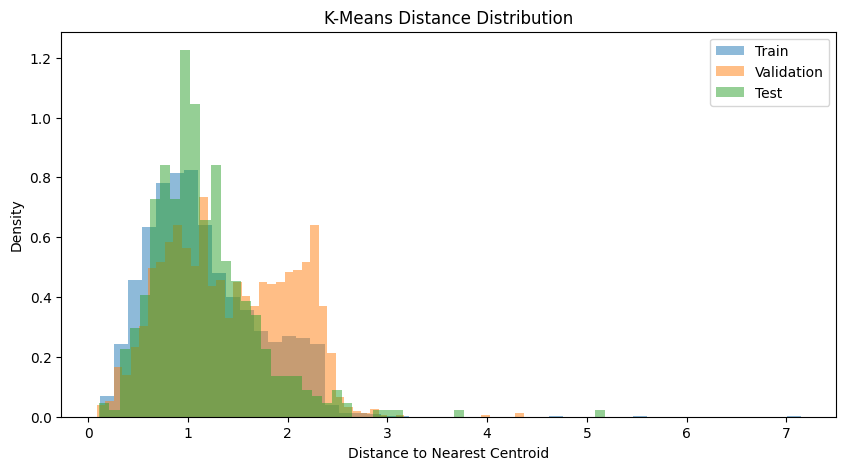

In [34]:
# VAL & TEST distances
val_dist, val_labels = compute_kmeans_distance(X_val_s, kmeans)
test_dist, test_labels = compute_kmeans_distance(X_test_s, kmeans)

plt.figure(figsize=(10, 5))

plt.hist(train_dist, bins=50, alpha=0.5, label="Train", density=True)
plt.hist(val_dist, bins=50, alpha=0.5, label="Validation", density=True)
plt.hist(test_dist, bins=50, alpha=0.5, label="Test", density=True)

plt.xlabel("Distance to Nearest Centroid")
plt.ylabel("Density")
plt.title("K-Means Distance Distribution")
plt.legend()
plt.show()


#### Detect K-Means Anomalies

In [35]:
df_kmeans_val = detect_kmeans_anomaly(
    distances=val_dist,
    labels=val_labels,
    thresholds=thresholds,
    meta=meta_val
)

df_kmeans_test = detect_kmeans_anomaly(
    distances=test_dist,
    labels=test_labels,
    thresholds=thresholds,
    meta=meta_test
)

print("Val anomalies:", len(df_kmeans_val))
print("Test anomalies:", len(df_kmeans_test))

df_kmeans_test.head()


Val anomalies: 214
Test anomalies: 18


,date,ticker,anomaly_flag,cluster,distance
0,2020-03-16,QQQ,1,0,2.909465
1,2020-01-31,AMZN,1,1,5.186013
2,2020-01-07,GOOGL,1,4,1.965098
3,2020-02-24,GOOGL,1,0,2.255744
4,2020-03-09,GOOGL,1,0,1.897919


#### Anomaly Count Over Time

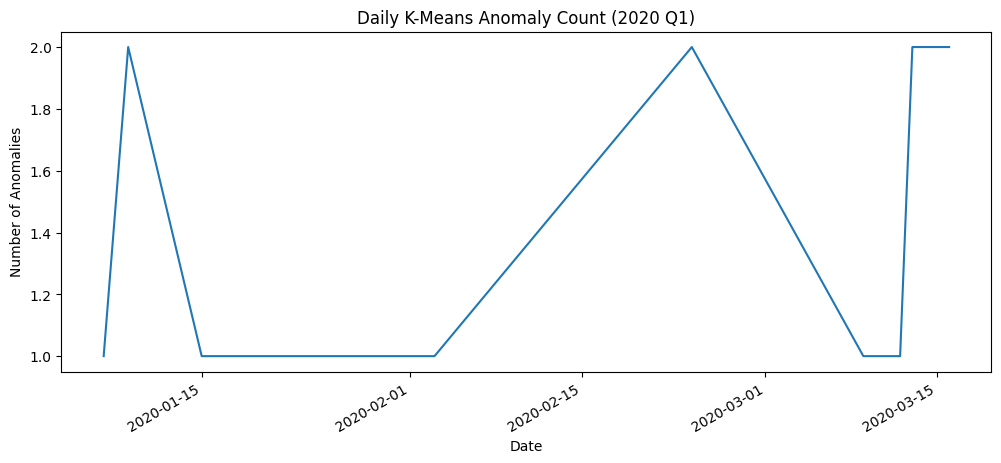

In [36]:
daily_counts = (
    df_kmeans_test
    .groupby("date")
    .size()
    .rename("kmeans_anomaly_count")
)

plt.figure(figsize=(12, 5))
daily_counts.plot()
plt.title("Daily K-Means Anomaly Count (2020 Q1)")
plt.ylabel("Number of Anomalies")
plt.xlabel("Date")
plt.show()


#### Rule-Based vs K-Means Comparison

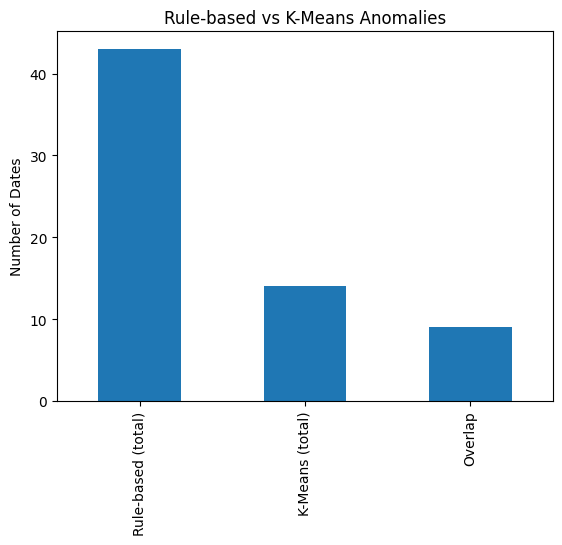

In [ ]:
df_rule = detect_rule_anomaly(df_features, ticker=None)
df_rule = df_rule[
    (df_rule["date"] >= "2020-01-01") &
    (df_rule["date"] <= "2020-03-31")
]
rule_dates = set(df_rule["date"])
kmeans_dates = set(df_kmeans_test["date"])

overlap = rule_dates & kmeans_dates

counts = {
    "Rule-based (total)": len(rule_dates),
    "K-Means (total)": len(kmeans_dates),
    "Overlap": len(overlap)
}

pd.Series(counts).plot(kind="bar", title="Rule-based vs K-Means Anomalies")
plt.ylabel("Number of Dates")
plt.savefig("reports/figures/rule_based_vs_Kmeans_anomaly.png", bbox_inches='tight')
plt.show()

In [38]:
len(rule_dates)

43

In [39]:
len(kmeans_dates)

14

In [41]:
len(overlap)

9